In [1]:
%pip install pytrends

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [13]:
import os
import time
import pandas as pd
import warnings
warnings.filterwarnings('ignore', category=FutureWarning, message='.*Downcasting object dtype arrays on .fillna, .ffill, .bfill.*')

from pytrends.request import TrendReq
import matplotlib.pyplot as plt

from utils import (
    COIN_DETAILS_FILE_PATH,
    GOOGLE_TRENDS_DATA_FILE_PATH,
    OHLCV_FILE_PATH,
    TRAIN_START_DATE,
    SAMPLE_SYMBOLS)

In [3]:
pytrends = TrendReq(hl='en-US', tz=360)

coin_info_data = pd.read_csv(COIN_DETAILS_FILE_PATH)
coin_info_data["keywords"] = coin_info_data["keywords"].astype(str)

# Create a mapping of symbols to their specific keywords
symbol_keyword_mapping = dict(zip(coin_info_data['symbol'], coin_info_data['keywords']))

def get_google_trends_data(keyword, retries=5, delay=5):
    attempt = 0
    while attempt < retries:
        try:
            pytrends.build_payload([keyword])
            trends_data = pytrends.interest_over_time()
            trends_data = trends_data.reset_index().infer_objects(copy=False)
            
            if not trends_data.empty:
                # Convert date to string format without time component
                trends_data['date'] = pd.to_datetime(trends_data['date']).dt.date
            
            return trends_data
        except Exception as e:
            if '429' in str(e):
                print(f"Received 429 error for {keyword}. Retrying after {delay} seconds...")
                time.sleep(delay)
                attempt += 1
                delay *= 2  # Exponential backoff
            else:
                print(f"Request failed for keywords {keyword}: {e}")
                break
    return pd.DataFrame()  # Return empty DataFrame on failure

already_downloaded = set()

# Initialize an empty DataFrame to store trends data
if os.path.exists(GOOGLE_TRENDS_DATA_FILE_PATH):
    all_trends_data = pd.read_csv(GOOGLE_TRENDS_DATA_FILE_PATH)
    already_downloaded = set(all_trends_data['symbol'].unique())
else:
    all_trends_data = pd.DataFrame()

# Extract unique names
unique_symbols = set(coin_info_data['symbol'].unique())

symbols_to_retrieve_set = unique_symbols - already_downloaded
print(f'Retrieving Google Trends Data for {len(symbols_to_retrieve_set)}')

keywords_to_retrieve = [symbol_keyword_mapping[symbol] for symbol in symbols_to_retrieve_set if symbol in symbol_keyword_mapping]

print (keywords_to_retrieve)
for i in range(0, len(keywords_to_retrieve)):
    keyword = keywords_to_retrieve[i]
    
    if len(keyword) > 4:
        try:
            print(f"Fetching data for: {keyword}, length: {len(keyword)}")
            trends_data = get_google_trends_data(keyword)
            if not trends_data.empty:

                # Filter and store only necessary columns that exist in the DataFrame
                existing_columns = ['date', keyword] if keyword in trends_data.columns else ['date']
                
                if len(existing_columns) > 1:  # Ensure there are columns other than 'date'
                    trends_data = trends_data[existing_columns]
                    
                    # Melt the DataFrame to have 'date', 'name', and 'value' columns
                    trends_data = trends_data.melt(id_vars=['date'], var_name='name', value_name='trend_score')
                    
                    # Add the symbol column based on the keyword
                    trends_data['symbol'] = trends_data['name'].map({v: k for k, v in symbol_keyword_mapping.items()})

                    # Reorder the columns to be date, symbol, trend_score
                    trends_data = trends_data[['date', 'symbol', 'name', 'trend_score']]

                    # Append to the main DataFrame
                    all_trends_data = pd.concat([all_trends_data, trends_data], ignore_index=True)
                    
                    # Save the updated DataFrame to CSV incrementally
                    all_trends_data.to_csv(GOOGLE_TRENDS_DATA_FILE_PATH, index=False)
            
            # Respect rate limiting
            time.sleep(5)
        
        except Exception as e:
            print(f"Failed to fetch data for {keyword}: {e}")

# Display the final DataFrame
all_trends_data.head()


Retrieving Google Trends Data for 6
['nan', 'nan', 'MintMe.com Coin', 'Ellipsis coin', 'Origin DeFi Governance', 'nan']
Fetching data for: MintMe.com Coin, length: 15
Received 429 error for MintMe.com Coin. Retrying after 5 seconds...
Received 429 error for MintMe.com Coin. Retrying after 10 seconds...
Fetching data for: Ellipsis coin, length: 13
Fetching data for: Origin DeFi Governance, length: 22


,date,symbol,name,trend_score
0,2019-08-04,BNX,BinaryX,0
1,2019-08-11,BNX,BinaryX,0
2,2019-08-18,BNX,BinaryX,0
3,2019-08-25,BNX,BinaryX,0
4,2019-09-01,BNX,BinaryX,0


In [18]:
# Filter the data based on TRAIN_START_DATE
trends_data = pd.read_csv(GOOGLE_TRENDS_DATA_FILE_PATH) 
print(trends_data.shape[0])

trends_data['date'] = pd.to_datetime(trends_data['date'])
trends_data = trends_data[trends_data['date'] >= TRAIN_START_DATE]

# Sort the data by date
trends_data = trends_data.sort_values(by='date')

# Check for duplicates in the trends_data
duplicates_in_trends = trends_data[trends_data.duplicated(subset=['symbol', 'date'], keep=False)]
print(f"Duplicates in trends_data: {duplicates_in_trends.shape[0]}")

print(f'Dropping duplicates')
trends_data = trends_data.drop_duplicates(subset=['symbol', 'date'], keep='first')

# Write the sorted data to a CSV file
trends_data.to_csv(GOOGLE_TRENDS_DATA_FILE_PATH, index=False)

print(trends_data.shape[0])
trends_data.head()

314574
Duplicates in trends_data: 3706
311522


,date,symbol,name,trend_score
0,2020-06-07,BNX,BinaryX,0
967,2020-06-07,STEP,Step Finance,19
966,2020-06-07,METAL,BADMAD ROBOTS,0
965,2020-06-07,KIN,Kin,40
964,2020-06-07,BRZE,Breeze coin,0


: 

# EDA

<Figure size 1200x600 with 0 Axes>

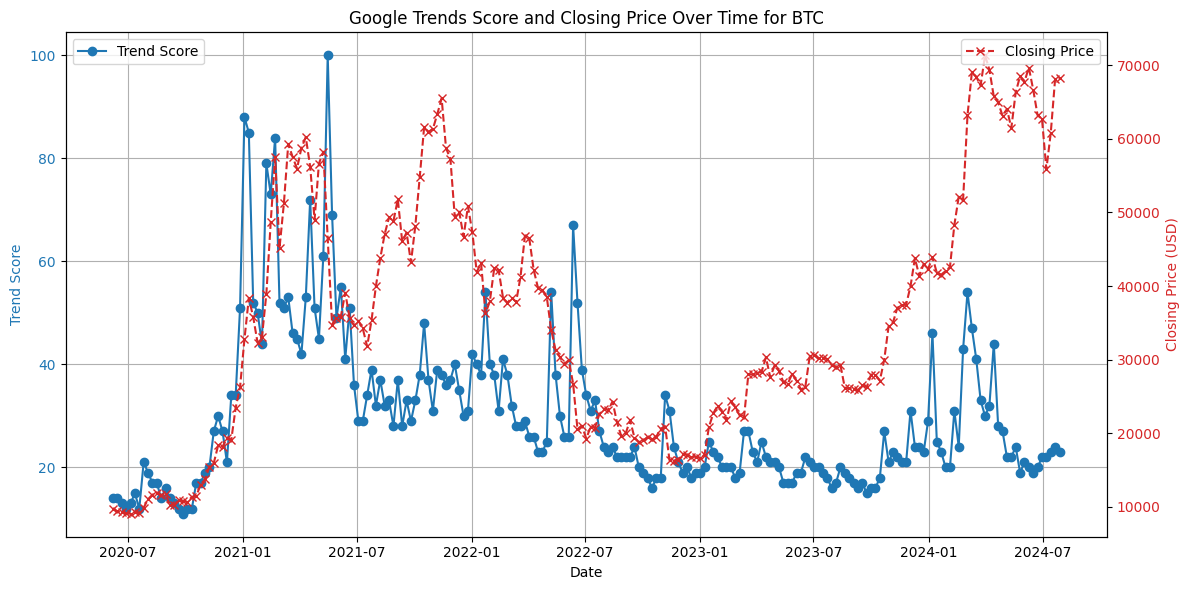

<Figure size 1200x600 with 0 Axes>

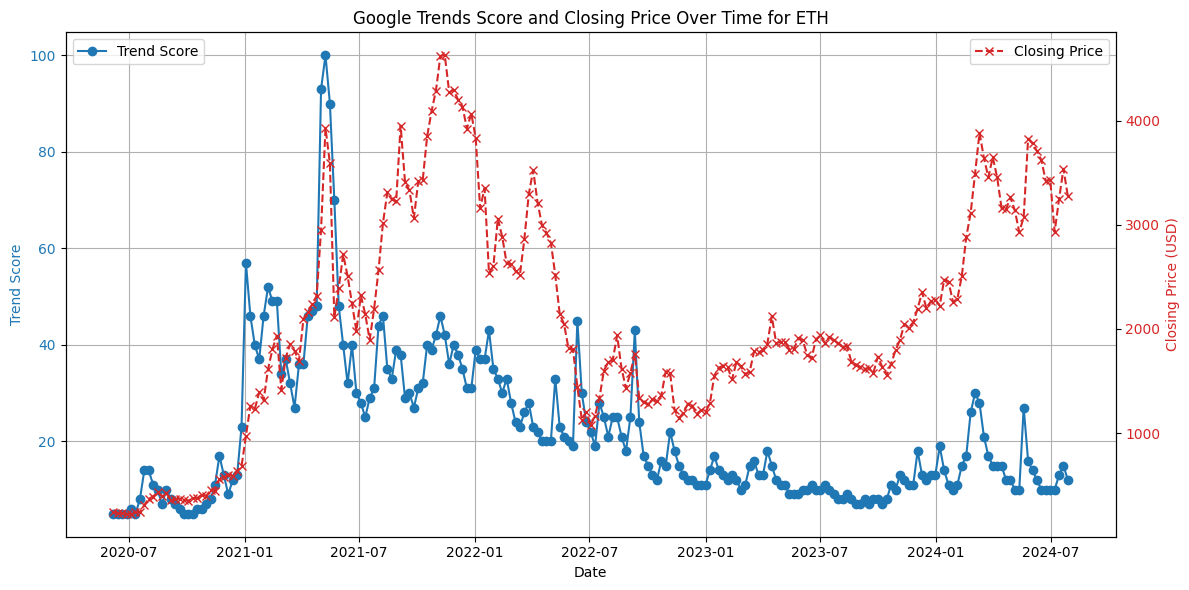

<Figure size 1200x600 with 0 Axes>

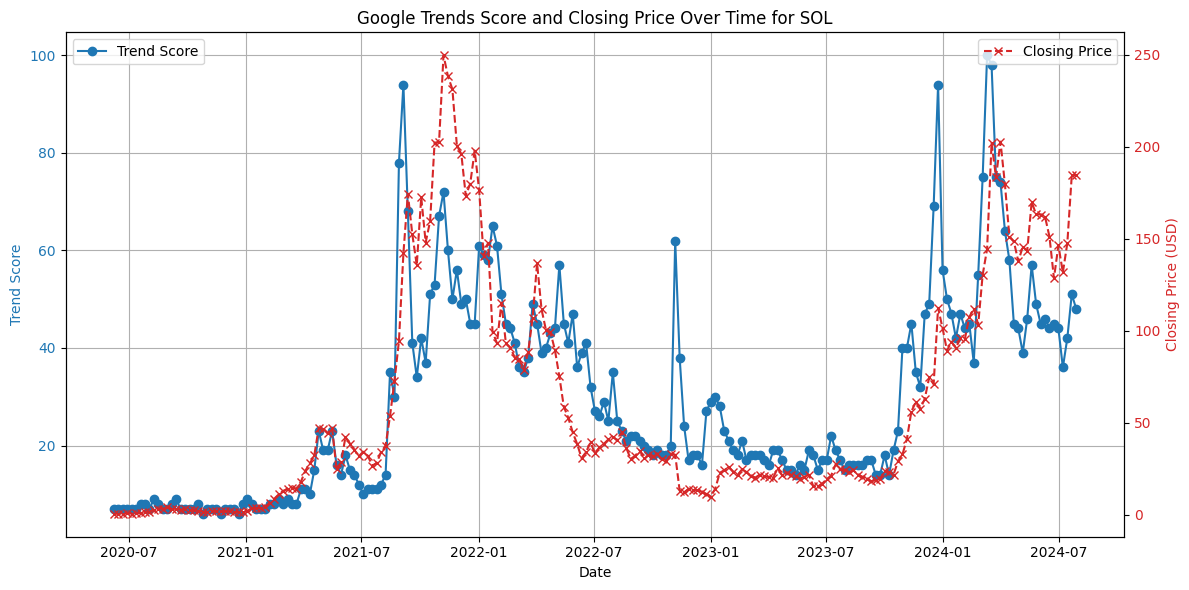

<Figure size 1200x600 with 0 Axes>

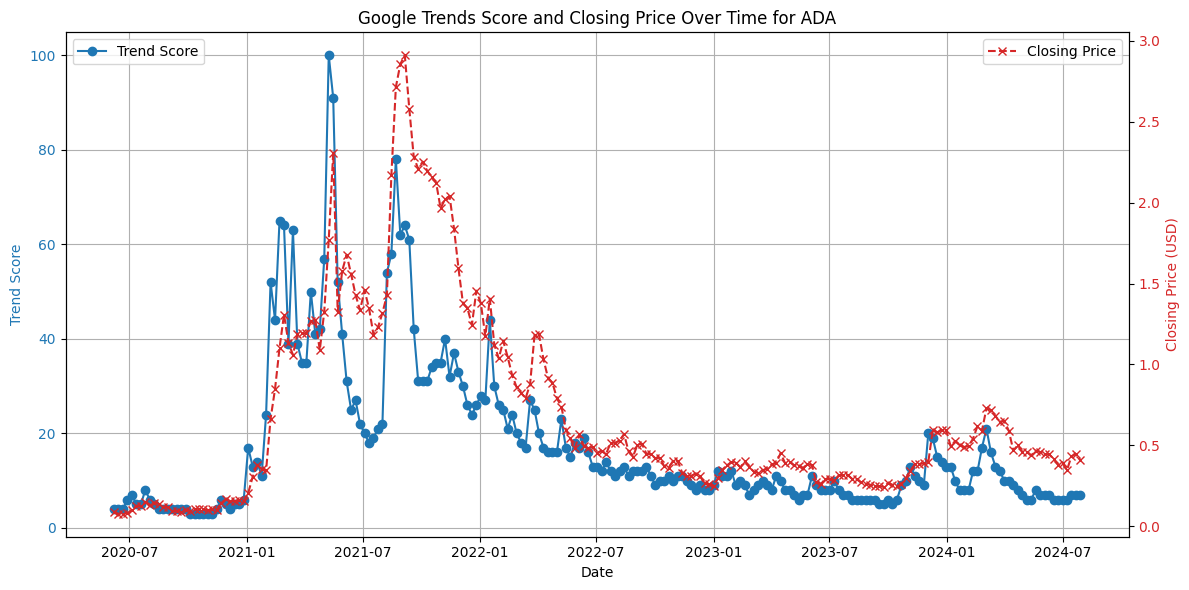

<Figure size 1200x600 with 0 Axes>

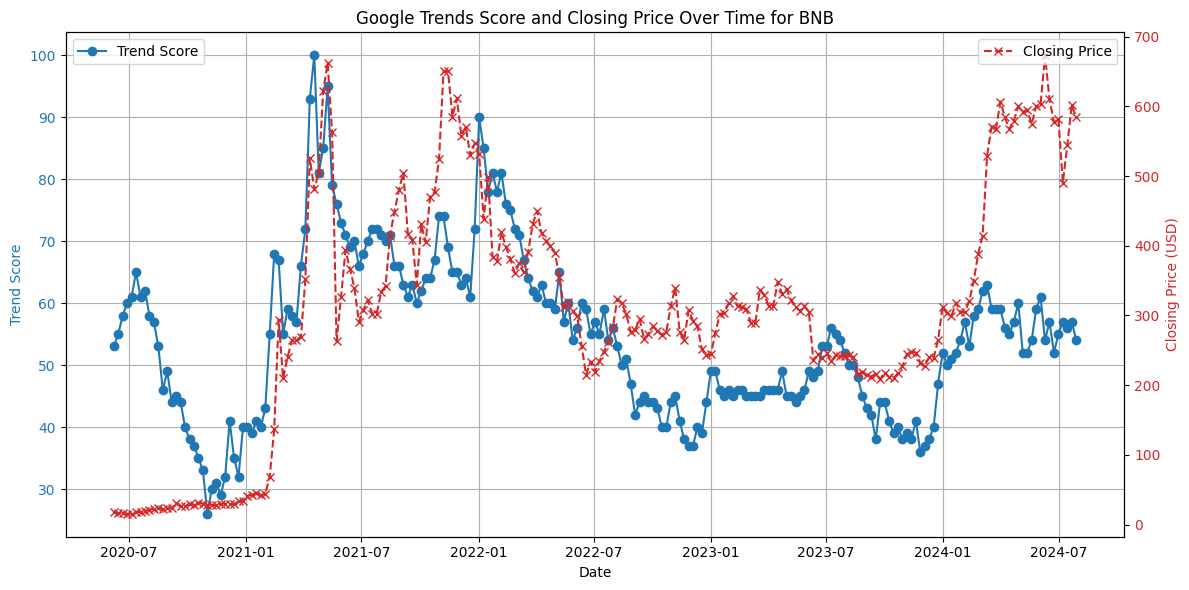

<Figure size 1200x600 with 0 Axes>

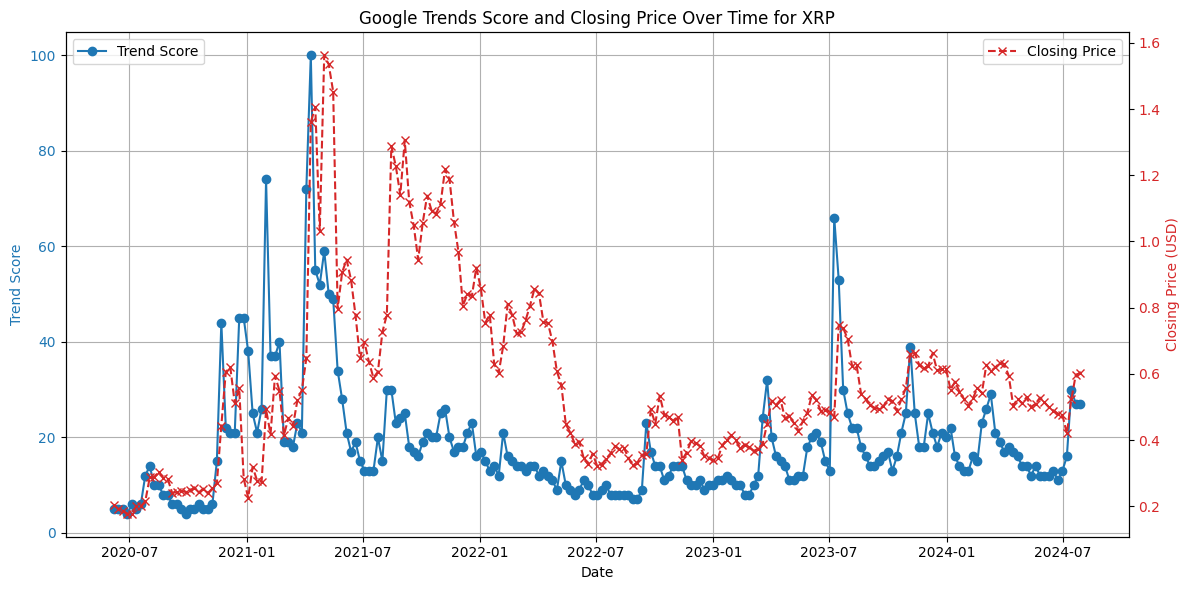

<Figure size 1200x600 with 0 Axes>

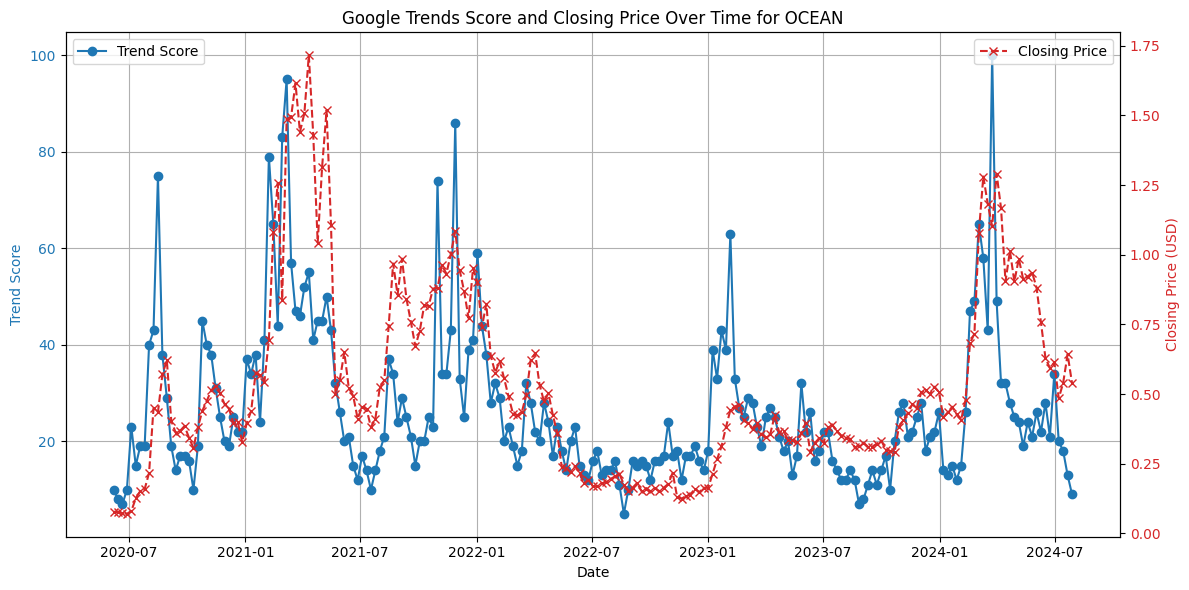

<Figure size 1200x600 with 0 Axes>

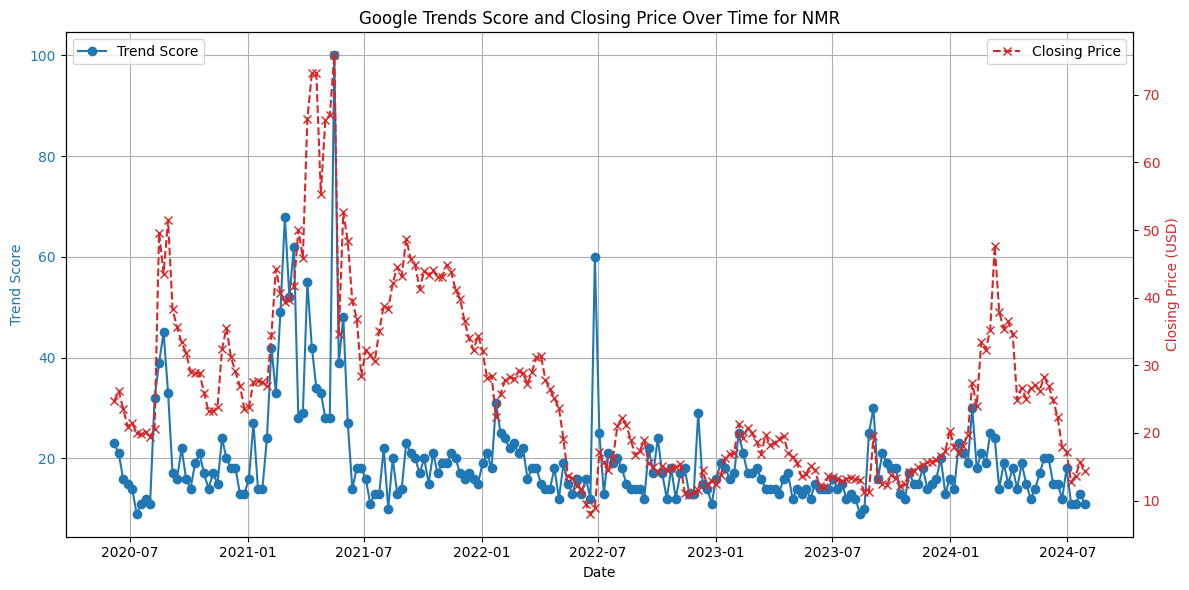

<Figure size 1200x600 with 0 Axes>

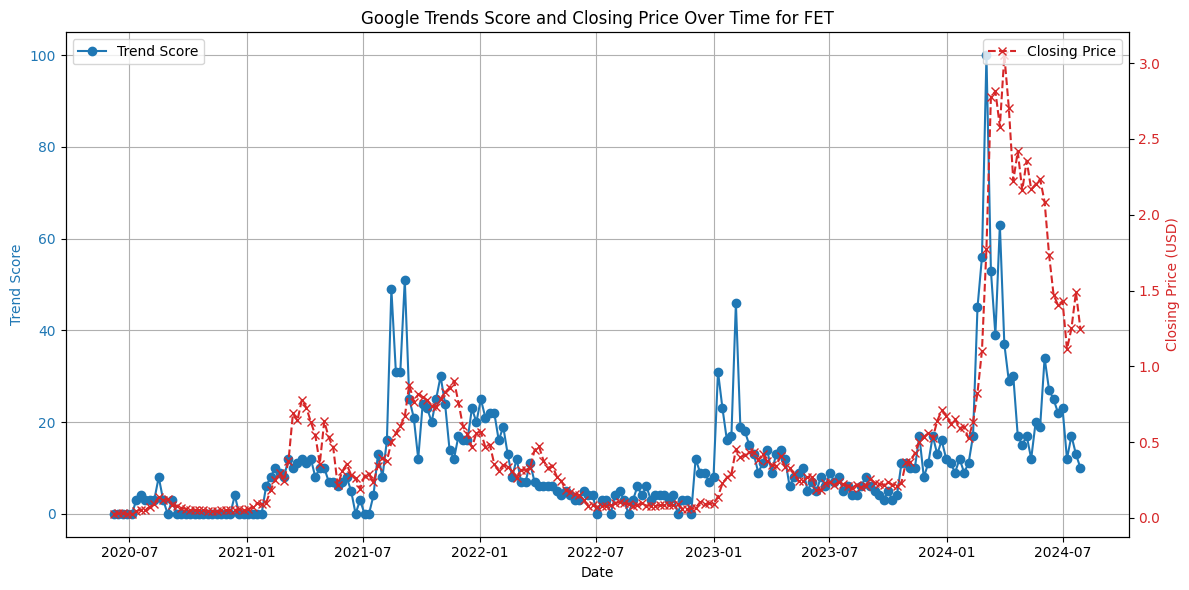

In [16]:
# Load Google Trends data
google_trends_data = pd.read_csv(GOOGLE_TRENDS_DATA_FILE_PATH)
google_trends_data['date'] = pd.to_datetime(google_trends_data['date']).dt.date

# Load pricing data
price_data = pd.read_csv(OHLCV_FILE_PATH)
price_data['date'] = pd.to_datetime(price_data['date']).dt.date

# Merge Google Trends data with pricing data
merged_data = pd.merge(google_trends_data, price_data, on=['symbol', 'date'], how='inner')

def plot_google_trends_and_prices(symbols):
    for symbol in symbols:
        plt.figure(figsize=(12, 6))
        symbol_data = merged_data[merged_data['symbol'] == symbol]
        
        fig, ax1 = plt.subplots(figsize=(12, 6))

        ax1.plot(symbol_data['date'], symbol_data['trend_score'], marker='o', linestyle='-', color='tab:blue', label='Trend Score')
        ax1.set_xlabel('Date')
        ax1.set_ylabel('Trend Score', color='tab:blue')
        ax1.tick_params(axis='y', labelcolor='tab:blue')
        ax1.grid(True)
        ax1.legend(loc='upper left')
        
        ax2 = ax1.twinx()
        ax2.plot(symbol_data['date'], symbol_data['close'], marker='x', linestyle='--', color='tab:red', label='Closing Price')
        ax2.set_ylabel('Closing Price (USD)', color='tab:red')
        ax2.tick_params(axis='y', labelcolor='tab:red')
        ax2.legend(loc='upper right')

        plt.title(f'Google Trends Score and Closing Price Over Time for {symbol}')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

# Plot the Google Trends data and closing prices for the sample symbols
plot_google_trends_and_prices(SAMPLE_SYMBOLS)


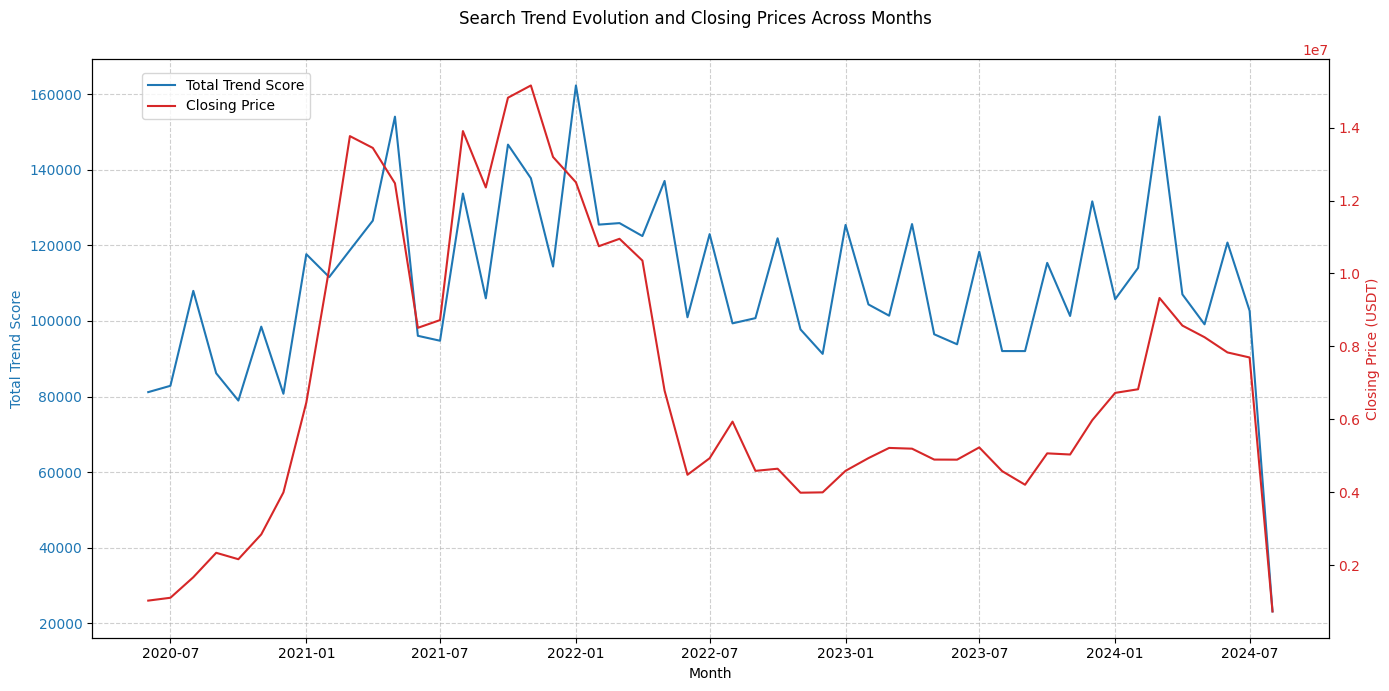

In [8]:

trend_df = pd.read_csv(GOOGLE_TRENDS_DATA_FILE_PATH)

# Load the pricing dataset
price_df = pd.read_csv(OHLCV_FILE_PATH)

# Ensure the date columns are in datetime format
trend_df['date'] = pd.to_datetime(trend_df['date'])
price_df['date'] = pd.to_datetime(price_df['date'])

# Extract year and month for trend scores
trend_df['year_month'] = trend_df['date'].dt.to_period('M')

# Group by year_month to calculate the total trend score
monthly_trends = trend_df.groupby('year_month')['trend_score'].sum().reset_index()

# Convert year_month back to datetime for plotting
monthly_trends['year_month'] = monthly_trends['year_month'].dt.to_timestamp()

# Extract year and month for prices
price_df['year_month'] = price_df['date'].dt.to_period('M')

# Group by year_month to calculate the average closing price
monthly_prices = price_df.groupby('year_month')['close'].sum().reset_index()

# Convert year_month back to datetime for plotting
monthly_prices['year_month'] = monthly_prices['year_month'].dt.to_timestamp()

# Merge the trend scores with the pricing information
merged_df = pd.merge(monthly_trends, monthly_prices, on='year_month', how='inner')

# Plotting
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot trend scores
ax1.plot(merged_df['year_month'], merged_df['trend_score'], color='tab:blue', label='Total Trend Score')
ax1.set_xlabel('Month')
ax1.set_ylabel('Total Trend Score', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
ax1.grid(True, linestyle='--', alpha=0.6)

# Create a secondary y-axis to plot the closing prices
ax2 = ax1.twinx()
ax2.plot(merged_df['year_month'], merged_df['close'], color='tab:red', label='Closing Price')
ax2.set_ylabel('Closing Price (USDT)', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Add a title and show the plot
fig.suptitle('Search Trend Evolution and Closing Prices Across Months')
fig.tight_layout()
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))
plt.show()

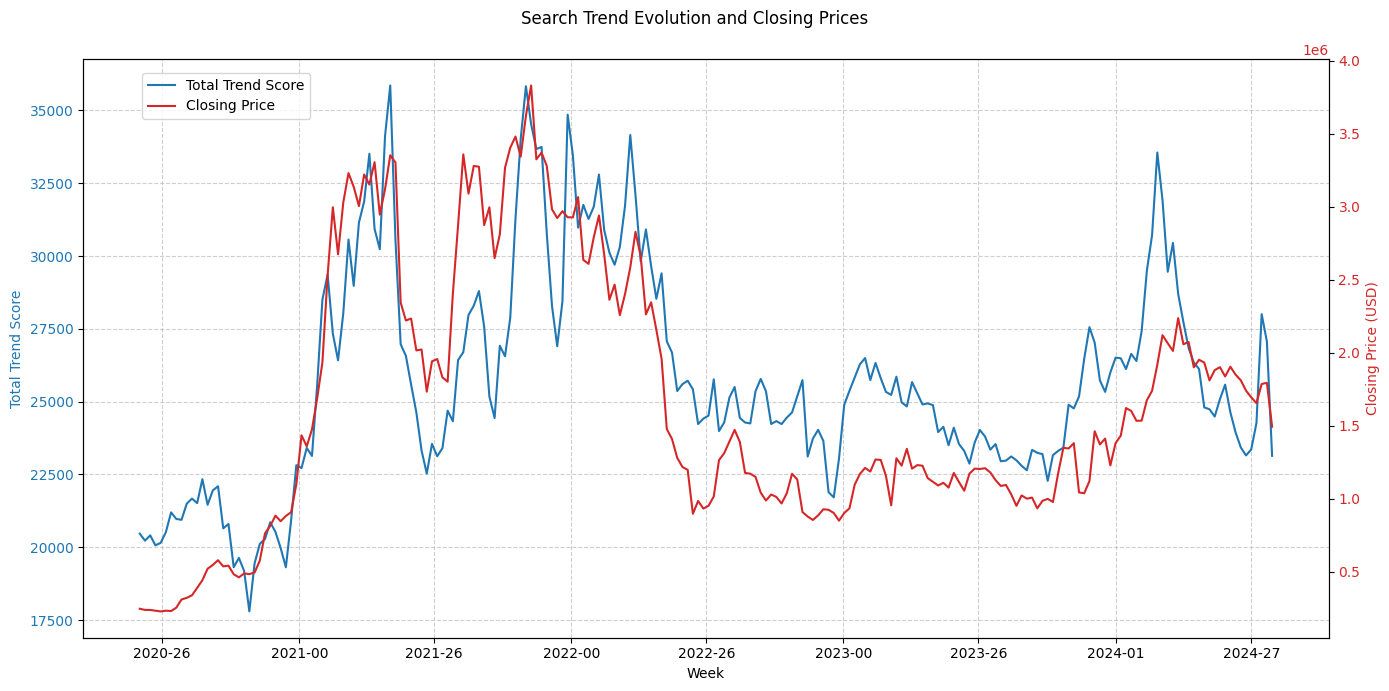

In [11]:
# Load the trend score dataset
trend_df = pd.read_csv(GOOGLE_TRENDS_DATA_FILE_PATH)

# Load the pricing dataset
price_df = pd.read_csv(OHLCV_FILE_PATH)

# Ensure the date columns are in datetime format
trend_df['date'] = pd.to_datetime(trend_df['date'])
price_df['date'] = pd.to_datetime(price_df['date'])

# Extract year and week for trend scores
trend_df['year_week'] = trend_df['date'].dt.to_period('W')

# Group by year_week to calculate the total trend score
weekly_trends = trend_df.groupby('year_week')['trend_score'].sum().reset_index()

# Convert year_week back to datetime for plotting
weekly_trends['year_week'] = weekly_trends['year_week'].dt.to_timestamp()

# Extract year and week for prices
price_df['year_week'] = price_df['date'].dt.to_period('W')

# Group by year_week to calculate the closing price
weekly_prices = price_df.groupby('year_week')['close'].sum().reset_index()

# Convert year_week back to datetime for plotting
weekly_prices['year_week'] = weekly_prices['year_week'].dt.to_timestamp()

# Merge the trend scores with the pricing information
merged_df = pd.merge(weekly_trends, weekly_prices, on='year_week', how='inner')

# Plotting
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot trend scores
ax1.plot(merged_df['year_week'], merged_df['trend_score'], color='tab:blue', label='Total Trend Score')
ax1.set_xlabel('Week')
ax1.set_ylabel('Total Trend Score', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%W'))
ax1.grid(True, linestyle='--', alpha=0.6)

# Create a secondary y-axis to plot the closing prices
ax2 = ax1.twinx()
ax2.plot(merged_df['year_week'], merged_df['close'], color='tab:red', label='Closing Price')
ax2.set_ylabel('Closing Price (USD)', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Add a title and show the plot
fig.suptitle('Search Trend Evolution and Closing Prices')
fig.tight_layout()
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))
plt.show()
